In [1]:
import numpy as np
from TMDP import TMDP
from algorithms import *
from model_functions import *

import matplotlib.pyplot as plt
import gymnasium as gym
from FrozenLake import *

#np.set_printoptions(precision=4)
import math
from utils import *

import torch
import mlflow
from CurriculumMPI import CurriculumMPI
import optuna

nrows = 10
nS = nrows**2
nA = 4
seed = get_current_seed()

gamma = .99
tau = .6
#tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)
#mdp = TMDP(river, xi, tau=0., gamma=gamma, seed=seed)

env = FrozenLakeEnv(is_slippery=False, seed=seed, desc=generate_random_map(nrows))#, render_mode="human")
xi = np.ones(env.nS) * 1/env.nS
tmdp = TMDP(env, xi, tau=tau, gamma=gamma, seed=seed)

Current seed for result reproducibility: 47146882006333120128184314011326542902


In [2]:
res = bellman_optimal_q(tmdp.env.P_mat, tmdp.env.reward, tmdp.gamma)
Q = res["Q"]
V = compute_V_from_Q(Q, get_policy(Q))

In [3]:

def get_or_create_experiment(experiment_name):
    if experiment := mlflow.get_experiment_by_name(experiment_name):
        return experiment.experiment_id
    else:
        return mlflow.create_experiment(experiment_name)


In [4]:
mlflow.set_tracking_uri("http://localhost:5000")
experiment_name = "Frozen_Lake_{}_{}_{}".format(nS, nA, tau)
experiment_id = get_or_create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/863678489242914479', creation_time=1715851854769, experiment_id='863678489242914479', last_update_time=1715851854769, lifecycle_stage='active', name='Frozen_Lake_25_4_0.6', tags={}>

In [5]:
episodes = 100000
final_temp=0.020

In [6]:

def objective(trial):
    with mlflow.start_run(nested=True):
        global episodes
        # Parameter space optimization
        model_lr = trial.suggest_float("model_lr", 1e-4, 0.5, log=False)
        pol_lr = trial.suggest_float("pol_lr", 1e-4, 0.5, log=False)
        batch_size = trial.suggest_int("batch_size", 1, 32, log=False)
        lam = trial.suggest_float("lam", 0., 1., log=False)
        temp = trial.suggest_float("temp", 0.1, 10, log=False)

        # Curriculum class initialization
        curr_MPI = CurriculumMPI(tmdp)
        
        tmdp.update_tau(tau) # Reset the teleport rate 
        
        curr_MPI.train(model_lr, pol_lr, batch_size=batch_size, 
                        lam=lam, temp=temp, final_temp=final_temp,
                        episodes=episodes, check_convergence=True,
                        param_decay=True)
        
        # Update the number of episodes clipping it between episodes/2 and episodes*2
        episodes = max(episodes/2, min(curr_MPI.episodes, episodes*2))
        
        avg_performance = np.average(curr_MPI.exp_performances[-10:]) # Optimize for the average performance
        avg_reward = np.average(curr_MPI.reward_records[-10:])
        
        mlflow.log_params({
            "model_lr": model_lr,
            "pol_lr": pol_lr,
            "batch_size": batch_size,
            "lam": lam,
            "temp": temp,
            "final_temp": final_temp,
        })

        """for i, perf in enumerate(curr_MPI.exp_performances):
            mlflow.log_metric(f"Epoch {i} Performance ", perf)"""

        mlflow.log_metric("Avg Performance", avg_performance)
        mlflow.log_metric("Avg Reward", avg_reward)

        mlflow.set_tags(tags={
        "Project": "Curriculum Learning",
        "Algorithm": "CurriculumMPI",
        "Environment": tmdp.env.__class__.__name__,
        "nS": nS,
        "nA": nA,
        "gamma": gamma,
        "mu": tmdp.env.mu,
        "xi": tmdp.xi,
        "seed": seed,
        "tau": tau,
        "episodes": curr_MPI.episodes,
        })
        curr_MPI.save_to_mlflow() # Save the model to MLflow

    return avg_performance


In [7]:


run_name = "Avg J Run"
with mlflow.start_run(experiment_id=experiment_id, run_name=run_name, nested=True):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=5)
    
    mlflow.log_params(study.best_params)
    
    # Train and save the best model
    curr_MPI = CurriculumMPI(tmdp)
    tmdp.update_tau(tau) # Reset the teleport rate 

    # Get the best parameters
    model_lr = study.best_params["model_lr"]
    pol_lr = study.best_params["pol_lr"]
    batch_size = study.best_params["batch_size"]
    lam = study.best_params["lam"]
    temp = study.best_params["temp"]
    
    # Train the best model
    curr_MPI.train(model_lr=model_lr,
                   pol_lr=pol_lr,
                   batch_size=batch_size,
                   lam=lam,
                   temp=temp,
                   final_temp=final_temp,
                   episodes=episodes)
    
    mlflow.set_tags(tags={
        "Project": "Curriculum Learning",
        "Algorithm": "CurriculumMPI",
        "Environment": tmdp.env.__class__.__name__,
        "nS": nS,
        "nA": nA,
        "gamma": gamma,
        "mu": tmdp.env.mu,
        "xi": tmdp.xi,
        "seed": seed,
        "tau": tau,
        "episodes": episodes,
        })

    curr_MPI.save_to_mlflow() # Save the best model to MLflow

[I 2024-05-16 11:36:10,294] A new study created in memory with name: no-name-6331471b-9d86-408c-afe9-b6772f05318e


Expected performance under current policy:  0.0
No valid pairs found
[(0.0, 0.6)]
Alpha*: 0.0 tau*: 0.6 Episode: 104 length: 37 #teleports:67
Time for bound evaluation:  0.004999876022338867
Expected performance under current policy:  0.0
No valid pairs found
[(0.0, 0.6)]
Alpha*: 0.0 tau*: 0.6 Episode: 226 length: 53 #teleports:69
Time for bound evaluation:  0.0010006427764892578
Got not null reward 1.0!
Expected performance under current policy:  0.0
[(1, 0.6), (0.0, 0.59998), (1.0, 0.60004)]
Alpha*: 1 tau*: 0.6 Episode: 332 length: 43 #teleports:63
Time for bound evaluation:  0.0010006427764892578
Expected performance under current policy:  0.0
[(1, 0.6), (0.0, 0.59998), (1.0, 0.6)]
Alpha*: 1.0 tau*: 0.6 Episode: 436 length: 45 #teleports:59
Time for bound evaluation:  0.0020003318786621094
Got not null reward 1.0!
Expected performance under current policy:  0.0
[(1, 0.6), (0.0, 0.59997), (1.0, 0.60007)]
Alpha*: 1 tau*: 0.6 Episode: 543 length: 47 #teleports:60
Time for bound evaluat

[I 2024-05-16 11:37:04,231] Trial 0 finished with value: 0.219466333091259 and parameters: {'model_lr': 0.42911252071909683, 'pol_lr': 0.1030522123710473, 'batch_size': 28, 'lam': 0.20319329698452893, 'temp': 7.552602465784081}. Best is trial 0 with value: 0.219466333091259.


Saved model at ./temp_model.pth
Model logged to MLflow and local file removed.
Expected performance under current policy:  0.0
No valid pairs found
[(0.0, 0.6)]
Alpha*: 0.0 tau*: 0.6 Episode: 3 length: 1 #teleports:2
Time for bound evaluation:  0.0010008811950683594
Expected performance under current policy:  0.0
No valid pairs found
[(0.0, 0.6)]
Alpha*: 0.0 tau*: 0.6 Episode: 7 length: 3 #teleports:1
Time for bound evaluation:  0.0009999275207519531
Expected performance under current policy:  0.0
No valid pairs found
[(0.0, 0.6)]
Alpha*: 0.0 tau*: 0.6 Episode: 9 length: 1 #teleports:1
Time for bound evaluation:  0.0020003318786621094
Expected performance under current policy:  0.0
No valid pairs found
[(0.0, 0.6)]
Alpha*: 0.0 tau*: 0.6 Episode: 14 length: 1 #teleports:4
Time for bound evaluation:  0.002000570297241211
Expected performance under current policy:  0.0
No valid pairs found
[(0.0, 0.6)]
Alpha*: 0.0 tau*: 0.6 Episode: 17 length: 1 #teleports:2
Time for bound evaluation:  0.

[I 2024-05-16 11:38:20,682] Trial 1 finished with value: 0.919637131690979 and parameters: {'model_lr': 0.32510085814327916, 'pol_lr': 0.19858989208642755, 'batch_size': 1, 'lam': 0.4718433115331897, 'temp': 8.333704323807194}. Best is trial 1 with value: 0.919637131690979.


Got not null reward 1.0!
Expected performance under current policy:  0.918980062007904
[(1, 0)]
Alpha*: 1 tau*: 0 Episode: 89046 length: 8 #teleports:0
Time for bound evaluation:  0.0010006427764892578
Got not null reward 1.0!
Expected performance under current policy:  0.9189996123313904
[(1, 0)]
Alpha*: 1 tau*: 0 Episode: 89054 length: 8 #teleports:0
Time for bound evaluation:  0.0010001659393310547
Got not null reward 1.0!
Expected performance under current policy:  0.9192284941673279
[(0.54999, 0), (0.54999, 0.0)]
Alpha*: 0.54999 tau*: 0 Episode: 89064 length: 10 #teleports:0
Time for bound evaluation:  0.0010001659393310547
Got not null reward 1.0!
Expected performance under current policy:  0.9192444682121277
[(0.8064, 0), (0.8064, 0.0)]
Alpha*: 0.8064 tau*: 0 Episode: 89072 length: 8 #teleports:0
Time for bound evaluation:  0.0010008811950683594
Got not null reward 1.0!
Expected performance under current policy:  0.9193829298019409
[(1, 0)]
Alpha*: 1 tau*: 0 Episode: 89080 lengt

[I 2024-05-16 11:39:19,017] Trial 2 finished with value: 0.5567319691181183 and parameters: {'model_lr': 0.16199653161737723, 'pol_lr': 0.07325937913466472, 'batch_size': 19, 'lam': 0.22167769222294031, 'temp': 1.8195356618052034}. Best is trial 1 with value: 0.919637131690979.


Got not null reward 19.0!
Expected performance under current policy:  0.561877965927124
[(0.00057, 0.00795), (0.0, 0.0077), (1.0, 0.34758)]
Alpha*: 0.0 tau*: 0.0077 Episode: 99991 length: 157 #teleports:0
Time for bound evaluation:  0.0020017623901367188
Sampling loop is over. Done flag: True, Terminated flag: False
Got not null reward 1.0!
Expected performance under current policy:  0.5618809461593628
[(0.00053, 0.0077), (0.0, 0.00745), (1.0, 0.34429)]
Alpha*: 0.0 tau*: 0.00745 Episode: 99999 length: 8 #teleports:0
Time for bound evaluation:  0.002001047134399414
Saved model at ./temp_model.pth
Model logged to MLflow and local file removed.
Expected performance under current policy:  0.0
No valid pairs found
[(0.0, 0.6)]
Alpha*: 0.0 tau*: 0.6 Episode: 97 length: 34 #teleports:63
Time for bound evaluation:  0.015003442764282227
Expected performance under current policy:  0.0
No valid pairs found
[(0.0, 0.6)]
Alpha*: 0.0 tau*: 0.6 Episode: 193 length: 42 #teleports:54
Time for bound eva

[I 2024-05-16 11:40:17,929] Trial 3 finished with value: 0.3840794742107391 and parameters: {'model_lr': 0.45244011474941914, 'pol_lr': 0.2502253708777682, 'batch_size': 22, 'lam': 0.4039152274198735, 'temp': 2.351861737620059}. Best is trial 1 with value: 0.919637131690979.


Model logged to MLflow and local file removed.
Expected performance under current policy:  0.0
No valid pairs found
[(0.0, 0.6)]
Alpha*: 0.0 tau*: 0.6 Episode: 127 length: 43 #teleports:84
Time for bound evaluation:  0.0010004043579101562
Expected performance under current policy:  0.0
No valid pairs found
[(0.0, 0.6)]
Alpha*: 0.0 tau*: 0.6 Episode: 242 length: 42 #teleports:73
Time for bound evaluation:  0.0009996891021728516
Got not null reward 2.0!
Expected performance under current policy:  0.0
[(1, 0.6), (0.0, 0.59997), (1.0, 0.60012)]
Alpha*: 1 tau*: 0.6 Episode: 362 length: 49 #teleports:71
Time for bound evaluation:  0.002000093460083008
Expected performance under current policy:  0.0
[(1, 0.6), (0.0, 0.59997), (1.0, 0.60001)]
Alpha*: 1 tau*: 0.6 Episode: 508 length: 50 #teleports:96
Time for bound evaluation:  0.0010006427764892578
Expected performance under current policy:  0.0
[(1, 0.6), (0.0, 0.59997), (1.0, 0.6)]
Alpha*: 1 tau*: 0.6 Episode: 624 length: 52 #teleports:64
Ti

[I 2024-05-16 11:41:11,151] Trial 4 finished with value: 0.20422262102365493 and parameters: {'model_lr': 0.29252575127042374, 'pol_lr': 0.020632662478006828, 'batch_size': 31, 'lam': 0.4344904367994086, 'temp': 3.12580910867769}. Best is trial 1 with value: 0.919637131690979.


Model logged to MLflow and local file removed.
Expected performance under current policy:  0.0
No valid pairs found
[(0.0, 0.6)]
Alpha*: 0.0 tau*: 0.6 Episode: 11 length: 2 #teleports:9
Time for bound evaluation:  0.0010001659393310547
Expected performance under current policy:  0.0
No valid pairs found
[(0.0, 0.6)]
Alpha*: 0.0 tau*: 0.6 Episode: 15 length: 1 #teleports:3
Time for bound evaluation:  0.0009999275207519531
Expected performance under current policy:  0.0
No valid pairs found
[(0.0, 0.6)]
Alpha*: 0.0 tau*: 0.6 Episode: 17 length: 1 #teleports:1
Time for bound evaluation:  0.0010001659393310547
Expected performance under current policy:  0.0
No valid pairs found
[(0.0, 0.6)]
Alpha*: 0.0 tau*: 0.6 Episode: 19 length: 1 #teleports:1
Time for bound evaluation:  0.0010004043579101562
Expected performance under current policy:  0.0
No valid pairs found
[(0.0, 0.6)]
Alpha*: 0.0 tau*: 0.6 Episode: 23 length: 2 #teleports:2
Time for bound evaluation:  0.0009999275207519531
Expected

In [8]:
print(Q)

delta_pol = get_policy(Q)-get_policy(get_softmax_policy(curr_MPI.thetas[-1]))
print(delta_pol)

r_s_a = compute_r_s_a(tmdp.env.P_mat, tmdp.env.reward)

V_Q = compute_V_from_Q(Q, get_policy(curr_MPI.Q))

V_curr = compute_V_from_Q(Q, get_softmax_policy(curr_MPI.theta))
V_ref = compute_V_from_Q(Q, get_softmax_policy(curr_MPI.theta_ref))

j_curr = compute_expected_j(V_curr, tmdp.env.mu)
j_curr_ref = compute_expected_j(V_ref, tmdp.env.mu)
j_q_curr = compute_expected_j(V_Q, tmdp.env.mu)
j_opt = compute_expected_j(V, tmdp.env.mu)
print("optimal performance: ",j_opt)
print("curriculum performance: ", j_curr)
print("reference curriculum performance: ",j_curr_ref)
print("Q curriculum performance: ",j_q_curr)

print(get_softmax_policy(curr_MPI.theta))

[[0.92274469 0.93206535 0.         0.92274469]
 [0.         0.         0.         0.        ]
 [0.         0.95099005 0.         0.94148015]
 [0.         0.         0.         0.        ]
 [0.         0.95099005 0.94148015 0.94148015]
 [0.93206535 0.94148015 0.94148015 0.92274469]
 [0.93206535 0.95099005 0.95099005 0.        ]
 [0.94148015 0.96059601 0.96059601 0.94148015]
 [0.95099005 0.970299   0.95099005 0.        ]
 [0.96059601 0.96059601 0.95099005 0.94148015]
 [0.94148015 0.95099005 0.95099005 0.93206535]
 [0.94148015 0.96059601 0.96059601 0.94148015]
 [0.95099005 0.970299   0.970299   0.95099005]
 [0.96059601 0.9801     0.96059601 0.96059601]
 [0.970299   0.         0.96059601 0.95099005]
 [0.95099005 0.96059601 0.96059601 0.94148015]
 [0.95099005 0.970299   0.970299   0.95099005]
 [0.96059601 0.9801     0.9801     0.96059601]
 [0.970299   0.99       0.         0.970299  ]
 [0.         0.         0.         0.        ]
 [0.96059601 0.96059601 0.970299   0.95099005]
 [0.96059601 

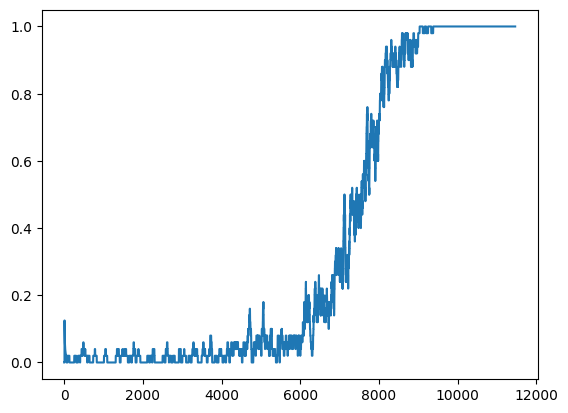

: 

In [20]:
import matplotlib.pyplot as plt
reward_records = curr_MPI.reward_records
# Generate recent 50 interval average
average_reward = []
scaled_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    scaled_reward.append(reward_records[idx]/batch_size)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list)/batch_size)
# Plot
#plt.plot(scaled_reward)
plt.plot(average_reward[:-1])

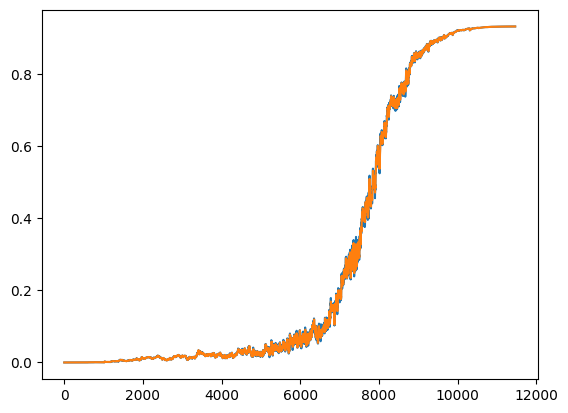

In [10]:
import matplotlib.pyplot as plt
exp_performances = curr_MPI.exp_performances
# Generate recent 50 interval average
avg_performances = []
for idx in range(len(exp_performances)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 5:
        avg_list = exp_performances[:idx+1]
    else:
        avg_list = exp_performances[idx-4:idx+1]
    avg_performances.append(np.average(avg_list))
# Plot
plt.plot(exp_performances)
plt.plot(avg_performances)

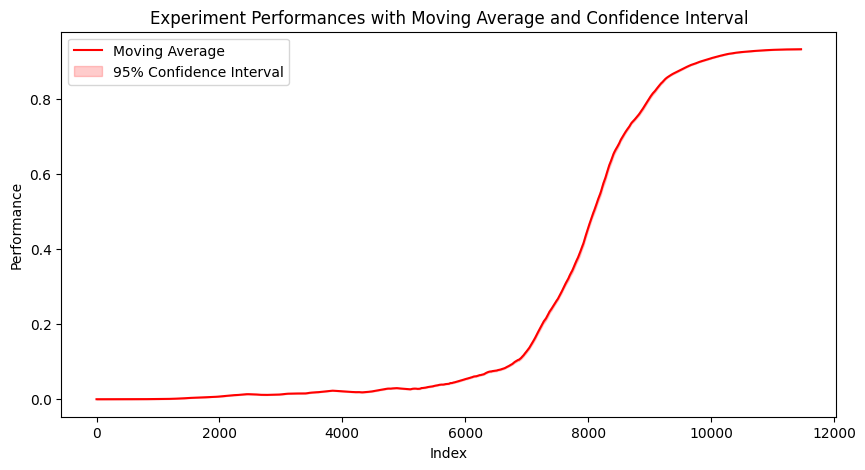

In [11]:
import matplotlib.pyplot as plt
import numpy as np

exp_performances = curr_MPI.exp_performances
# Generate recent 50 interval average
avg_performances = []
std_errors = []

for idx in range(len(exp_performances)):
    if idx < 500:
        avg_list = exp_performances[:idx+1]
    else:
        avg_list = exp_performances[idx-499:idx+1]

    average = np.average(avg_list)
    std_dev = np.std(avg_list)
    n_samples = len(avg_list)
    sem = std_dev / np.sqrt(n_samples)  # Standard Error of the Mean
    std_errors.append(sem)

    avg_performances.append(average)

# Compute the upper and lower bounds for the 95% confidence interval
ci = 1.96  # Z-score for 95% confidence
upper_bound = [avg + ci * sem for avg, sem in zip(avg_performances, std_errors)]
lower_bound = [avg - ci * sem for avg, sem in zip(avg_performances, std_errors)]

# Plot
plt.figure(figsize=(10, 5))
#plt.plot(exp_performances, label='Exp Performances')
plt.plot(avg_performances, label='Moving Average', color='r')
plt.fill_between(range(len(avg_performances)), lower_bound, upper_bound, color='r', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.title('Experiment Performances with Moving Average and Confidence Interval')
plt.xlabel('Index')
plt.ylabel('Performance')
plt.show()


In [12]:
pi = get_policy(get_softmax_policy(curr_MPI.theta))
tmdp.update_tau(0.)
tmdp.reset()
done = False
step = 0
env.render_mode = "human"
while True:
    s = tmdp.env.s
    a = greedy(tmdp.env.s, pi, tmdp.env.allowed_actions[int(tmdp.env.s)])
    s_prime, reward, flags, prob = tmdp.step(a)
    print("state {} action {} next state {} reward {}".format(s, a, s_prime, reward))
    if flags["done"]:
        tmdp.reset()
    step +=1
    if step > max(100,nrows*2):
        break


state 0 action 1 next state 5 reward 0.0
state 5 action 1 next state 10 reward 0.0
state 10 action 1 next state 15 reward 0.0
state 15 action 1 next state 20 reward 0.0
state 20 action 2 next state 21 reward 0.0
state 21 action 2 next state 22 reward 0.0
state 22 action 2 next state 23 reward 0.0
state 23 action 2 next state 24 reward 1.0
state 0 action 1 next state 5 reward 0.0
state 5 action 1 next state 10 reward 0.0
state 10 action 1 next state 15 reward 0.0
state 15 action 1 next state 20 reward 0.0
state 20 action 2 next state 21 reward 0.0
state 21 action 2 next state 22 reward 0.0
state 22 action 2 next state 23 reward 0.0
state 23 action 2 next state 24 reward 1.0
state 0 action 1 next state 5 reward 0.0
state 5 action 1 next state 10 reward 0.0
state 10 action 1 next state 15 reward 0.0
state 15 action 1 next state 20 reward 0.0
state 20 action 2 next state 21 reward 0.0
state 21 action 2 next state 22 reward 0.0
state 22 action 2 next state 23 reward 0.0
state 23 action 2 ne